In [1]:
from fastai.collab import *
import pandas as pd
import numpy as np

In [2]:
url_books = 'https://raw.githubusercontent.com/TannerGilbert/Tutorials/master/Recommendation%20System/books.csv'
url_ratings = 'https://raw.githubusercontent.com/TannerGilbert/Tutorials/master/Recommendation%20System/ratings.csv'

In [3]:
ratings = pd.read_csv(url_ratings, error_bad_lines=False, warn_bad_lines=False)

In [4]:
print(ratings.head(5))
print('---------------------')
print(ratings.shape)
print('---------------------')
print(ratings.isnull().sum())


   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4
---------------------
(981756, 3)
---------------------
book_id    0
user_id    0
rating     0
dtype: int64


In [5]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [6]:
data.show_batch()

user_id,book_id,target
38990,9040,3.0
14563,6765,4.0
3205,5499,4.0
6689,4680,2.0
36752,2404,4.0


In [7]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

### EmbeddingDotBias Model

In [8]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [9]:
print(learn.summary())

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 400,040    True      
______________________________________________________________________
Embedding            [1]                  53,351     True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________

Total params: 2,597,432
Total trainable params: 2,597,432
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


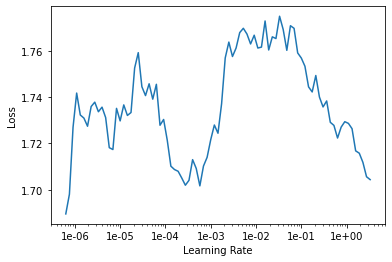

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,time
0,1.594781,1.589042,01:25
1,1.303363,1.309850,01:25
2,1.086796,1.124759,01:26
3,1.037156,1.061335,01:27
4,1.001634,1.051944,01:27


In [12]:
learn.save('goodbooks-dot-1')

### EmbeddingNN Model

In [13]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


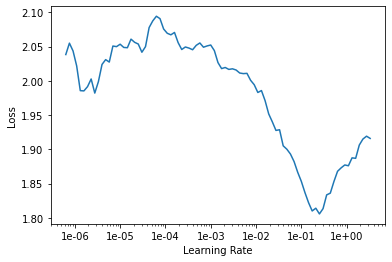

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.775666,0.770553,01:47
1,0.743732,0.741402,01:46
2,0.725416,0.721545,01:46
3,0.662722,0.707203,01:47
4,0.630768,0.716814,01:45


In [16]:
learn.save('goodbooks-nn-1')

### Interpretation

In [17]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1')

CollabLearner(data=TabularDataBunch;

Train: LabelList (883581 items)
x: CollabList
user_id 314; book_id 1; ,user_id 439; book_id 1; ,user_id 588; book_id 1; ,user_id 1169; book_id 1; ,user_id 1185; book_id 1; 
y: FloatList
5.0,3.0,5.0,4.0,4.0
Path: .;

Valid: LabelList (98175 items)
x: CollabList
user_id 19643; book_id 6495; ,user_id 8563; book_id 6175; ,user_id 52110; book_id 9920; ,user_id 33864; book_id 215; ,user_id 16587; book_id 2728; 
y: FloatList
5.0,4.0,3.0,5.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(53351, 40)
  (i_weight): Embedding(10001, 40)
  (u_bias): Embedding(53351, 1)
  (i_bias): Embedding(10001, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('/tmp'), model_dir='/tmp/model/', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbac

In [18]:
books = pd.read_csv(url_books, error_bad_lines=False, warn_bad_lines=False)

In [19]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [20]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['5000', '3315', '3313', '3312', '3311', '3309', '3308', '3307', '3306', '3304'], dtype='<U21')

In [25]:
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)
top_books_with_name

array(['Passion Unleashed (Demonica #3)', 'My Story', 'The Gargoyle', 'Pretty Baby', ...,
       'Top Secret Twenty-One (Stephanie Plum, #21)', 'The Warrior Heir (The Heir Chronicles, #1)', 'Stone Soup',
       'The Sixth Man (Sean King & Michelle Maxwell, #5)'], dtype='<U144')

### Book Bias

In [26]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53351, 40)
  (i_weight): Embedding(10001, 40)
  (u_bias): Embedding(53351, 1)
  (i_bias): Embedding(10001, 1)
)

In [27]:
book_bias = learn.bias(top_books, is_item=True)

In [28]:
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

In [29]:
item0 = lambda o:o[0]

In [30]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.1082), 'The Almost Moon', 2.49),
 (tensor(-0.0380), 'The Particular Sadness of Lemon Cake', 2.93),
 (tensor(-0.0320), 'Skinny Bitch', 2.9),
 (tensor(-0.0311), 'Bergdorf Blondes', 3.0),
 (tensor(-0.0142), 'The Weird Sisters', 3.08),
 (tensor(-0.0095), 'Nightfall (The Vampire Diaries: The Return, #1)', 3.12),
 (tensor(-0.0094), 'Swamplandia!', 3.02),
 (tensor(0.0018), 'Need (Need, #1)', 3.22),
 (tensor(0.0048),
  'The Claiming of Sleeping Beauty (Sleeping Beauty, #1)',
  3.28),
 (tensor(0.0063), 'Last Night at Chateau Marmont', 3.07),
 (tensor(0.0078), 'Vampire Kisses (Vampire Kisses, #1)', 3.18),
 (tensor(0.0095), 'Skipping Christmas', 3.25),
 (tensor(0.0107), 'Wreckage', 3.13),
 (tensor(0.0123), 'Lipstick Jungle', 3.12),
 (tensor(0.0147), 'Ink Exchange (Wicked Lovely, #2)', 3.29)]

In [31]:
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.3134),
  'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
  4.77),
 (tensor(0.3099), 'The Kindly Ones (The Sandman #9)', 4.65),
 (tensor(0.3080), 'The Wake (The Sandman #10)', 4.65),
 (tensor(0.3061), 'Saga, Vol. 4 (Saga, #4)', 4.5),
 (tensor(0.3011), 'The Story of a New Name (The Neapolitan Novels #2)', 4.23),
 (tensor(0.3008),
  'The Story of the Lost Child (The Neapolitan Novels, #4)',
  4.38),
 (tensor(0.3005), 'The Bands of Mourning (Mistborn, #6)', 4.37),
 (tensor(0.3005), 'The Complete Calvin and Hobbes', 4.73),
 (tensor(0.2973), 'Nimona', 4.4),
 (tensor(0.2968),
  'Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D',
  4.57),
 (tensor(0.2945), 'Just Mercy: A Story of Justice and Redemption', 4.51),
 (tensor(0.2940), 'Saga, Vol. 3 (Saga, #3)', 4.54),
 (tensor(0.2913), 'Crooked Kingdom (Six of Crows, #2)', 4.55),
 (tensor(0.2909), 'The Arrival', 4.45),
 (tensor(0.2893), 'A Game of You (The Sandman #5)', 4.56)]

In [32]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [33]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [34]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

In [35]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.6811), 'The Kindly Ones (The Sandman #9)'),
 (tensor(0.6708), 'The Complete Calvin and Hobbes'),
 (tensor(0.6548), 'A Game of You (The Sandman #5)'),
 (tensor(0.6473), 'The Wake (The Sandman #10)'),
 (tensor(0.5692), "Worlds' End (The Sandman #8)"),
 (tensor(0.5630), 'Fables and Reflections (The Sandman #6)'),
 (tensor(0.5309),
  "The Hitchhiker's Guide to the Galaxy: A Trilogy in Four Parts"),
 (tensor(0.5277), 'Pale Fire'),
 (tensor(0.5212), 'The Complete Stories'),
 (tensor(0.5186), 'SantaLand Diaries')]

In [36]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.7791), 'Fueled (Driven, #2)'),
 (tensor(-0.7727), 'Pulse (Collide, #2)'),
 (tensor(-0.7572), 'Driven (Driven, #1)'),
 (tensor(-0.7402), 'Beautiful Stranger (Beautiful Bastard, #2)'),
 (tensor(-0.7162), 'Twisted Perfection (Rosemary Beach, #5; Perfection, #1)'),
 (tensor(-0.7056), 'Just for Now (Sea Breeze, #4)'),
 (tensor(-0.7035), 'A Beautiful Wedding (Beautiful, #2.5)'),
 (tensor(-0.6991), 'One Week Girlfriend (One Week Girlfriend, #1)'),
 (tensor(-0.6965), 'Feast of Fools (The Morganville Vampires, #4)'),
 (tensor(-0.6842), 'The Vincent Brothers (The Vincent Boys, #2)')]

In [37]:
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]

In [38]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.3685), 'Swamplandia!'),
 (tensor(0.3353), 'The Weird Sisters'),
 (tensor(0.3136), 'Skinny Bitch'),
 (tensor(0.2949), 'Wreckage'),
 (tensor(0.2871), 'Housekeeping'),
 (tensor(0.2857), 'The Particular Sadness of Lemon Cake'),
 (tensor(0.2856), 'Sweet Tooth'),
 (tensor(0.2800), 'Sons and Lovers'),
 (tensor(0.2792), 'Super Sad True Love Story'),
 (tensor(0.2777), 'The Almost Moon')]

In [39]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.5912), 'Executive Power (Mitch Rapp, #6)'),
 (tensor(-0.5692), 'Kill Shot (Mitch Rapp, #2)'),
 (tensor(-0.5452), "The 9th Judgment  (Women's Murder Club, #9)"),
 (tensor(-0.5343), 'Term Limits'),
 (tensor(-0.5321), 'The Sixth Man (Sean King & Michelle Maxwell, #5)'),
 (tensor(-0.5298), 'Extreme Measures (Mitch Rapp, #11)'),
 (tensor(-0.5281), 'Winter Prey (Lucas Davenport, #5)'),
 (tensor(-0.5269), 'Pursuit of Honor (Mitch Rapp, #12)'),
 (tensor(-0.5268), 'Buried Prey (Lucas Davenport, #21)'),
 (tensor(-0.5227), 'The Third Option (Mitch Rapp, #4)')]

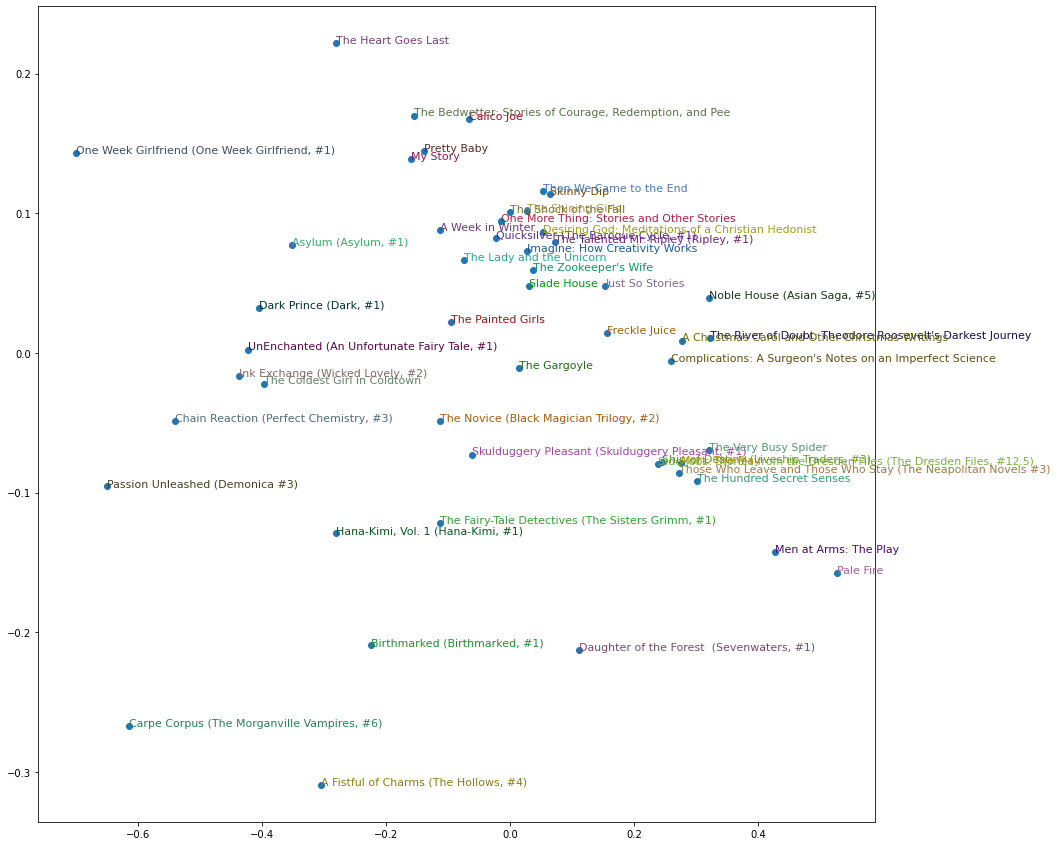

In [40]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()